In [68]:
import pandas as pd
import pickle as pkl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from pytorch_transformers import BertTokenizer, BertForMaskedLM, BertForSequenceClassification, BertConfig
from util import *

# get gt based on sst labels

In [118]:
sents_arr = np.loadtxt('data/sentiment_labels.txt', dtype=str, delimiter='|')
id_to_sent = {sents_arr[i, 0]: float(sents_arr[i, 1]) for i in range(1, sents_arr.shape[0])}

phrases = open('data/dictionary.txt', 'r').read().split('\n') #[:10000]
phrase_to_id = {}
for line in phrases:
    try:
        s, phrase_id = line.split('|')
        if all([c.isalpha() for c in s]):
            phrase_to_id[s.lower()] = phrase_id
    except:
        pass
    
phrase_to_sent = {
    phrase: id_to_sent[phrase_to_id[phrase]] for phrase in phrase_to_id if phrase_to_id[phrase] in id_to_sent
}

In [169]:
scores_lime = pkl.load(open('scores_lime_0.pkl', 'rb'))
scores_lime = {'lime': scores_lime['lime']}

scores = pkl.load(open('scores_31.pkl', 'rb'))
ks = list(set(scores['iid'].keys()).intersection(set(phrase_to_sent.keys())))
results = {
    key: [np.mean(scores[key][k]) for k in ks] for key in scores.keys()
}
results['word'] = ks
results['gt'] = [2 * (phrase_to_sent[k] - 0.5) for k in ks]
r = pd.DataFrame(results)
print('num points', r.shape[0])

num points 293


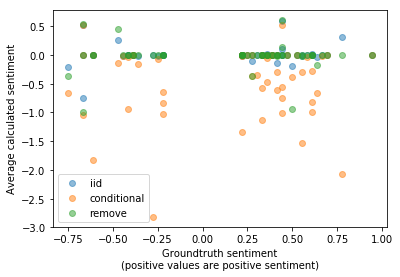

In [177]:
r = pd.DataFrame(results)
r = r[np.abs(r["gt"]) > 0.2]

for key in ['iid', 'conditional', 'remove']:
    plt.plot(r['gt'], r[key], 'o', alpha=0.5)
plt.xlabel('Groundtruth sentiment\n(positive values are positive sentiment)')
plt.ylabel('Average calculated sentiment')
plt.legend()
# plt.xlim((-1, 1))
# plt.ylim((-1, 1))
plt.show()

In [179]:
r = pd.DataFrame(results)
r = r[np.abs(r["gt"]) > 0.1]

print('spearman')
print(f'iid: {spearmanr(r["gt"], r["iid"])[0]:0.2f}, \
remove: {spearmanr(r["gt"], r["remove"])[0]:0.2f} \
cond: {spearmanr(r["gt"], r["conditional"])[0]:0.2f}')

print('pearson')
print(f'iid: {np.corrcoef(r["gt"], r["iid"])[0, 1]:0.2f}, \
remove: {np.corrcoef(r["gt"], r["remove"])[0, 1]:0.2f} \
cond: {np.corrcoef(r["gt"], r["conditional"])[0, 1]:0.2f}')

spearman
iid: 0.10, remove: 0.06 cond: 0.01
pearson
iid: 0.10, remove: 0.03 cond: -0.00
